# Proyek Analisis Sentimen pada Review Sebuah Restoran

Tujuan dari proyek ini adalah untuk membuat sebuah model yang dapat memprediksi apakah review sebuah restoran merupakan review positif atau negatif. Proyek ini menggunakan [dataset yield](https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set), dataset tersebut yang berisi kumpulan review terhap sebuah restoran.

In [1]:
import pandas as pd
import tensorflow.compat.v1 as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, GlobalAveragePooling1D, Dense#, LSTM, Bidirectional
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
import json


KeyboardInterrupt



## Mempersiapkan Dataset

In [4]:
df = pd.read_csv('yelp_labelled.txt', names=['sentence', 'label'], sep='\t')
df.head()

,sentence,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1000 non-null   object
 1   label     1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


Berdasarkan keterangan di atas diketahui bahwa dataset yang digunakan terdiri dari 1000 data dan tidak terdapat *missing value*.

## Preprocessing Data

### Mengubah seluruh text kedalam bentuk lowercase

In [6]:
df['sentence'] = df['sentence'].str.lower()

df.head()

,sentence,label
0,wow... loved this place.,1
1,crust is not good.,0
2,not tasty and the texture was just nasty.,0
3,stopped by during the late may bank holiday of...,1
4,the selection on the menu was great and so wer...,1


### Menghilangkan [stopwords](https://en.wikipedia.org/wiki/Stop_word)

In [7]:
#nltk.download('stopwords')

In [8]:
stop_word = set(stopwords.words('english'))

df['sentence'] = df['sentence'].apply(lambda x:' '.join([word for word in x.split() if word not in (stop_word)]))

df.head()

,sentence,label
0,wow... loved place.,1
1,crust good.,0
2,tasty texture nasty.,0
3,stopped late may bank holiday rick steve recom...,1
4,selection menu great prices.,1


### Melakukan split dataset

In [9]:
sentence = df['sentence'].values
label = df['label'].values

In [10]:
sentence_train, sentence_test, label_train, label_test = train_test_split(sentence, label, test_size=0.2, shuffle=False)

print('Training dataset:\n', sentence_train.shape, label_train.shape)
print('\nTest dataset:\n', sentence_test.shape, label_test.shape)

Training dataset:
 (800,) (800,)

Test dataset:
 (200,) (200,)


### Membuat tokenisasi

In [11]:
filt = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ' # Untuk menghilangkan symbols

tokenizer = Tokenizer(num_words=2000, oov_token="<OOV>", filters=filt)

tokenizer.fit_on_texts(sentence_train)

In [12]:
word_index = tokenizer.word_index
print(len(word_index))

1720


In [13]:
# Menyimpan word_index kedalam sebuah file json

with open('word_index.json', 'w') as fp:
    json.dump(word_index, fp)

### Membuat sequences dan melakukan padding

In [14]:
train_sekuens = tokenizer.texts_to_sequences(sentence_train)
test_sekuens = tokenizer.texts_to_sequences(sentence_test)


train_padded = pad_sequences(train_sekuens, 
                             maxlen=20,
                             padding='post',
                             truncating='post')
test_padded = pad_sequences(test_sekuens,
                            maxlen=20,
                            padding='post',
                            truncating='post')

In [15]:
train_padded.shape

(800, 20)

In [16]:
test_padded.shape

(200, 20)

## Membuat Model

In [17]:
model = tf.keras.Sequential([
    Embedding(2000, 20, input_length=20),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 20)            40000     
                                                                 
 global_average_pooling1d (  (None, 20)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 43457 (169.75 KB)
Trainable params: 43457 (169.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [18]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Melatih Model

In [19]:
num_epochs = 30
history = model.fit(train_padded, label_train, 
                    epochs=num_epochs, 
                    validation_data=(test_padded, label_test),
                    verbose=1)

Epoch 1/30


25/25 [==============================] - 2s 23ms/step - loss: 0.6885 - accuracy: 0.5650 - val_loss: 0.7470 - val_accuracy: 0.2400
Epoch 2/30
25/25 [==============================] - 0s 5ms/step - loss: 0.6822 - accuracy: 0.5650 - val_loss: 0.7571 - val_accuracy: 0.2400
Epoch 3/30
25/25 [==============================] - 0s 5ms/step - loss: 0.6739 - accuracy: 0.5650 - val_loss: 0.7690 - val_accuracy: 0.2400
Epoch 4/30
25/25 [==============================] - 0s 5ms/step - loss: 0.6535 - accuracy: 0.5813 - val_loss: 0.7578 - val_accuracy: 0.2500
Epoch 5/30
25/25 [==============================] - 0s 5ms/step - loss: 0.5955 - accuracy: 0.6950 - val_loss: 0.6930 - val_accuracy: 0.4600
Epoch 6/30
25/25 [==============================] - 0s 5ms/step - loss: 0.4777 - accuracy: 0.8450 - val_loss: 0.6285 - val_accuracy: 0.6400
Epoch 7/30
25/25 [==============================] - 0s 5ms/step - loss: 0.3316 - accuracy: 0.9225 - val_loss: 0.5993 - val_accuracy: 0.6700
Epoch 8/30
25/25 

## Evaluasi Model

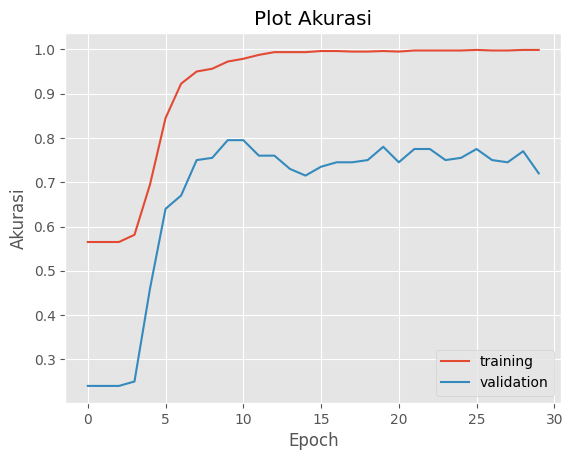

In [20]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="training")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="validation")
plt.title("Plot Akurasi")
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.legend()
plt.savefig('images/plot_acc.png')
plt.show()

Berdasarkan plot tersebut dapat dilihat bahwa model yang digunakan masih sangat overfit 

## Save Model

In [21]:
model.save("model.h5")

d:\UB\Dicoding\GitHub\Dicoding_Akmal\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Convert Model

In [22]:
# mengubah model.h5 kedalam bentuk json
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model


Traceback (most recent call last):
  File "C:\Users\akmal\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\akmal\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "d:\UB\Dicoding\GitHub\Dicoding_Akmal\.venv\Scripts\tensorflowjs_converter.exe\__main__.py", line 4, in <module>
  File "d:\ub\dicoding\github\dicoding_akmal\.venv\lib\site-packages\tensorflowjs\__init__.py", line 21, in <module>
    from tensorflowjs import converters
  File "d:\ub\dicoding\github\dicoding_akmal\.venv\lib\site-packages\tensorflowjs\converters\__init__.py", line 21, in <module>
    from tensorflowjs.converters.converter import convert
  File "d:\ub\dicoding\github\dicoding_akmal\.venv\lib\site-packages\tensorflowjs\converters\converter.py", line 38, in <module>
    from tensorflowjs.converters import tf_saved_model_conversion_v2
  File "d:\ub\dicod